Adapted from https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [1]:
import numpy as np
import pandas as pd
from keras import Sequential
from keras.layers import LSTM, Dense, TimeDistributed
from pandas import read_csv
from datetime import datetime
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error
%matplotlib inline

Using TensorFlow backend.


In [2]:
# This is a dataset that reports on the weather and the 
# level of pollution each hour for five years at the US 
# embassy in Beijing, China
# 
# No: row number
# year: year of data in this row
# month: month of data in this row
# day: day of data in this row
# hour: hour of data in this row
# pm2.5: PM2.5 concentration
# DEWP: Dew Point
# TEMP: Temperature
# PRES: Pressure
# cbwd: Combined wind direction
# Iws: Cumulated wind speed
# Is: Cumulated hours of snow
# Ir: Cumulated hours of rain


In [3]:
# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


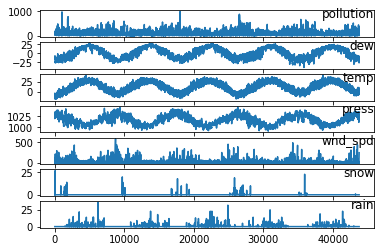

In [4]:

# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
        pyplot.subplot(len(groups), 1, i)
        pyplot.plot(values[:, group])
        pyplot.title(dataset.columns[group], y=0.5, loc='right')
        i += 1
pyplot.show()

In [5]:
# Function to slice the data into:
# input: [0:n_in] steps
# output: [0:n_out] steps


def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out+1):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 


In [6]:
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify the number of lag hours
n_hours = 10
n_features = 8

# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, n_hours)
print(reframed.shape)



(43780, 168)


In [7]:
# split into train and test sets


values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_obs]
test_X, test_y = test[:, :n_obs], test[:, -n_obs]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
train_y = train_X.reshape((train_X.shape[0], n_hours, n_features))
train_y = train_y[:,:,-n_features]
train_y = np.expand_dims(train_y,2)
test_y = test_X.reshape((test_X.shape[0], n_hours, n_features))
test_y = test_y[:,:,-n_features]
test_y = np.expand_dims(test_y,2)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 10, 8) (8760, 10, 1) (35020, 10, 8) (35020, 10, 1)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 8760 samples, validate on 35020 samples
Epoch 1/20
 - 2s - loss: 0.0048 - val_loss: 0.0058
Epoch 2/20
 - 1s - loss: 0.0020 - val_loss: 0.0024
Epoch 3/20
 - 1s - loss: 0.0013 - val_loss: 0.0014
Epoch 4/20
 - 1s - loss: 9.0888e-04 - val_loss: 0.0011
Epoch 5/20
 - 1s - loss: 6.6517e-04 - val_loss: 9.4130e-04
Epoch 6/20
 - 1s - loss: 5.0126e-04 - val_loss: 8.2669e-04
Epoch 7/20
 - 1s - loss: 3.7904e-04 - val_loss: 7.2955e-04
Epoch 8/20
 - 1s - loss: 2.8431e-04 - val_loss: 6.2723e-04
Epoch 9/20
 - 1s - loss: 2.1006e-04 - val_loss: 5.1461e-04
Epoch 10/20
 - 1s - loss: 1.5233e-04 - val_loss: 4.0842e-04
Epoch 11/20
 - 1s - loss: 1.0885e-04 - val_loss: 3.2192e-04
Epoch 12/20
 - 1s - loss: 7.7486e-05 - val_loss: 2.5814e-04
Epoch 13/20
 - 1s - loss: 5.6041e-05 - val_loss: 2.1665e-04
Epoch 14/20
 - 1s - loss: 4.1746e-05 - val_loss: 1.8875e-04
Epoch 15/20
 - 1s - loss: 3.

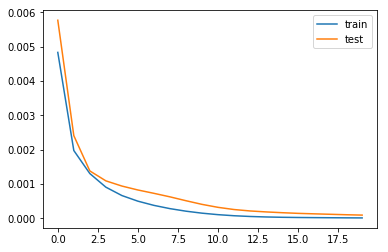

In [8]:
 
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
model.add(TimeDistributed(Dense(1))) # Repeats the dense layers overtop the LSTM outputs
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [9]:
# make a prediction
yhat = model.predict(test_X)

# calculate RMSE
rmse= np.zeros((yhat.shape[0],1))
for i in range(yhat.shape[0]):
    rmse[i] = np.sqrt(mean_squared_error(test_y[i,:], yhat[i,:]))
print('Test RMSE: %.3f' % np.mean(rmse))

Test RMSE: 0.008


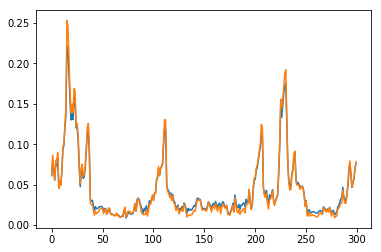

In [10]:
# 
pyplot.figure()
pyplot.plot(yhat[:,:,0].flatten()[np.arange(2500,5500,n_hours)])
pyplot.plot(test_y[:,:,0].flatten()[np.arange(2500,5500,n_hours)])